In [1]:
!pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

from pandas_profiling import ProfileReport
import numpy as np
import pandas as pd
import os
from gc_utils import *
from keras import backend as K

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

     | 54.5MB 495kB/s
     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 604kB 7.1MB/s 
     |████████████████████████████████| 3.1MB 11.8MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 296kB 40.0MB/s 
TensorFlow version: 2.3.0


# Load `Used Cars` dataset

In [2]:
API_TOKEN = {"username":"littleotter","key":"b952707737a70884d1d2a8a200709c56"}
URL = 'lepchenkov/usedcarscatalog'
kaggle_download(URL, API_TOKEN, unzip=True)

Setting up Kaggle for Google Colab...
Unzipping files...


## Build Profile Report of `Used Cars` for EDA

In [3]:
cars = pd.read_csv('Kaggle Downloads/cars.csv')
cars.head()

manufacturer_name model_name  ... feature_9 duration_listed
0            Subaru    Outback  ...      True              16
1            Subaru    Outback  ...      True              83
2            Subaru   Forester  ...      True             151
3            Subaru    Impreza  ...     False              86
4            Subaru     Legacy  ...      True               7

[5 rows x 30 columns]

In [4]:
profile = ProfileReport(cars, title="Pandas Profiling Report")

In [5]:
profile

## Handle Warnings

In [6]:
# Drop duplicate rows
df = cars.copy().drop_duplicates()

# Engine type contains values for engine fuel and not engines so remove feature
df.drop('engine_type', axis=1, inplace=True)

# Select all rows where at least 200 models were sold
model_frequencies = df['model_name'].value_counts()
model_names = model_frequencies[model_frequencies > 200]
df = df[df['model_name'].isin(model_names.index)]

# There's high correlation between manufacturer_name and model_name
# Drop manufacturer_name as model_name is more specific
df.drop('manufacturer_name', axis=1, inplace=True)

# Reset index
df = df.reset_index().drop('index', axis=1)

## Convert Datatypes

In [7]:
df.head()

model_name transmission   color  ...  feature_8  feature_9 duration_listed
0      Omega   mechanical   brown  ...       True       True               2
1     Zafira   mechanical    blue  ...       True       True               5
2     Vectra   mechanical  violet  ...      False       True              15
3     Vectra   mechanical  silver  ...      False       True              15
4     Vectra   mechanical  violet  ...      False       True              15

[5 rows x 28 columns]

In [8]:
df.dtypes

model_name           object
transmission         object
color                object
odometer_value        int64
year_produced         int64
engine_fuel          object
engine_has_gas         bool
engine_capacity     float64
body_type            object
has_warranty           bool
state                object
drivetrain           object
price_usd           float64
is_exchangeable        bool
location_region      object
number_of_photos      int64
up_counter            int64
feature_0              bool
feature_1              bool
feature_2              bool
feature_3              bool
feature_4              bool
feature_5              bool
feature_6              bool
feature_7              bool
feature_8              bool
feature_9              bool
duration_listed       int64
dtype: object

In [9]:
def convert_dtypes(df):
  """Converts datatypes of the `Used Cars` dataset
    
    Arg:
        df: `Used Cars` dataframe
    
    Return:
        returns the dataframe with the converted datatypes
  """
  df['odometer_value'] = df['odometer_value'].astype('float64')
  df['number_of_photos'] = df['number_of_photos'].astype('float64')
  df['up_counter'] = df['up_counter'].astype('float64')
  df['duration_listed'] = df['duration_listed'].astype('float64')

  bool_cols = df.select_dtypes('bool').columns
  for col in bool_cols:
    df[col] = df[col].map({True: 1, False: 0})

  return df

In [10]:
# Convert datatypes
df = convert_dtypes(df)

# Split data
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

8985 train examples
2247 validation examples
2809 test examples


In [11]:
df.dtypes

model_name           object
transmission         object
color                object
odometer_value      float64
year_produced         int64
engine_fuel          object
engine_has_gas        int64
engine_capacity     float64
body_type            object
has_warranty          int64
state                object
drivetrain           object
price_usd           float64
is_exchangeable       int64
location_region      object
number_of_photos    float64
up_counter          float64
feature_0             int64
feature_1             int64
feature_2             int64
feature_3             int64
feature_4             int64
feature_5             int64
feature_6             int64
feature_7             int64
feature_8             int64
feature_9             int64
duration_listed     float64
dtype: object

# Preprocessing Layers

In [12]:
def get_normalization_layer(name, dataset):
  """Normalizes feature data
    
    Arg:
        name: name of feature to process
        dataset: tf.data.dataset
    
    Return:
        returns the normalized feature
  """
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [13]:
# Encoding integer categorical features via one-hot encoding
def get_integer_categorical_encoding_layer(name, dataset):
  """One-hot encodes integer categorical feature data
    
    Arg:
        name: name of feature to process
        dataset: tf.data.dataset
    
    Return:
        returns the one-hot encoding
  """

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Use IntegerLookup to build an index of the feature values
  indexer = preprocessing.IntegerLookup()

  indexer.adapt(feature_ds)
  
  # Use CategoryEncoding to encode the integer indices to a one-hot vector
  encoder = preprocessing.CategoryEncoding(output_mode="binary")

  feature_ds = feature_ds.map(indexer)
  
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(indexer(feature))

In [14]:
# Encoding string categorical features via one-hot encoding
def get_string_categorical_encoding_layer(name, dataset):
  """One-hot encodes string categorical feature data
    
    Arg:
        name: name of feature to process
        dataset: tf.data.dataset
    
    Return:
        returns the one-hot encoding
  """

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Use StringLookup to build an index of the feature values
  indexer = preprocessing.StringLookup()
  indexer.adapt(feature_ds)
  
  # Use CategoryEncoding to encode the integer indices to a one-hot vector
  encoder = preprocessing.CategoryEncoding(output_mode="binary")

  feature_ds = feature_ds.map(indexer)

  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(indexer(feature))

# Process Dataset

In [15]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
  """One-hot encodes string categorical feature data
    
    Arg:
        name: name of feature to process
        dataset: tf.data.dataset
    
    Return:
        returns the one-hot encoding
  """
  df = df.copy()
  labels = df.pop('price_usd')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [26]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [27]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in train.drop('price_usd', axis=1).select_dtypes('float').columns:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [28]:
# Integer features
for header in train.select_dtypes('int64').columns:
  integer_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  integer_categorical_encoding_layer = get_integer_categorical_encoding_layer(header, train_ds)
  encoded_integer_col = integer_categorical_encoding_layer(integer_col)
  all_inputs.append(integer_col)
  encoded_features.append(encoded_integer_col)

In [29]:
# String features
for header in train.select_dtypes('object').columns:
  string_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  string_categorical_encoding_layer = get_string_categorical_encoding_layer(header, train_ds)
  encoded_string_col = string_categorical_encoding_layer(string_col)
  all_inputs.append(string_col)
  encoded_features.append(encoded_string_col)

# Custom Metrics

In [30]:
def r2_adj(y_true, y_pred):
  """Calculates the adjusted R squared metric
    
    Arg:
        y_true: actual values
        y_pred: predicted values
    
    Return:
        returns the one-hot encoding
  """
  n = 8985.
  k = 27.
  unexplained_error = K.mean(K.pow(y_true - y_pred, 2))
  total_error = K.mean(K.pow(y_true - K.mean(y_true), 2)) 
  r2 = 1. - (unexplained_error / total_error)
  r2_adj = 1 - ((1. - r2)*(n-1)/(n-k-1.)) 
  return r2_adj

# Build Model

In [34]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), r2_adj])

## Visualize Model

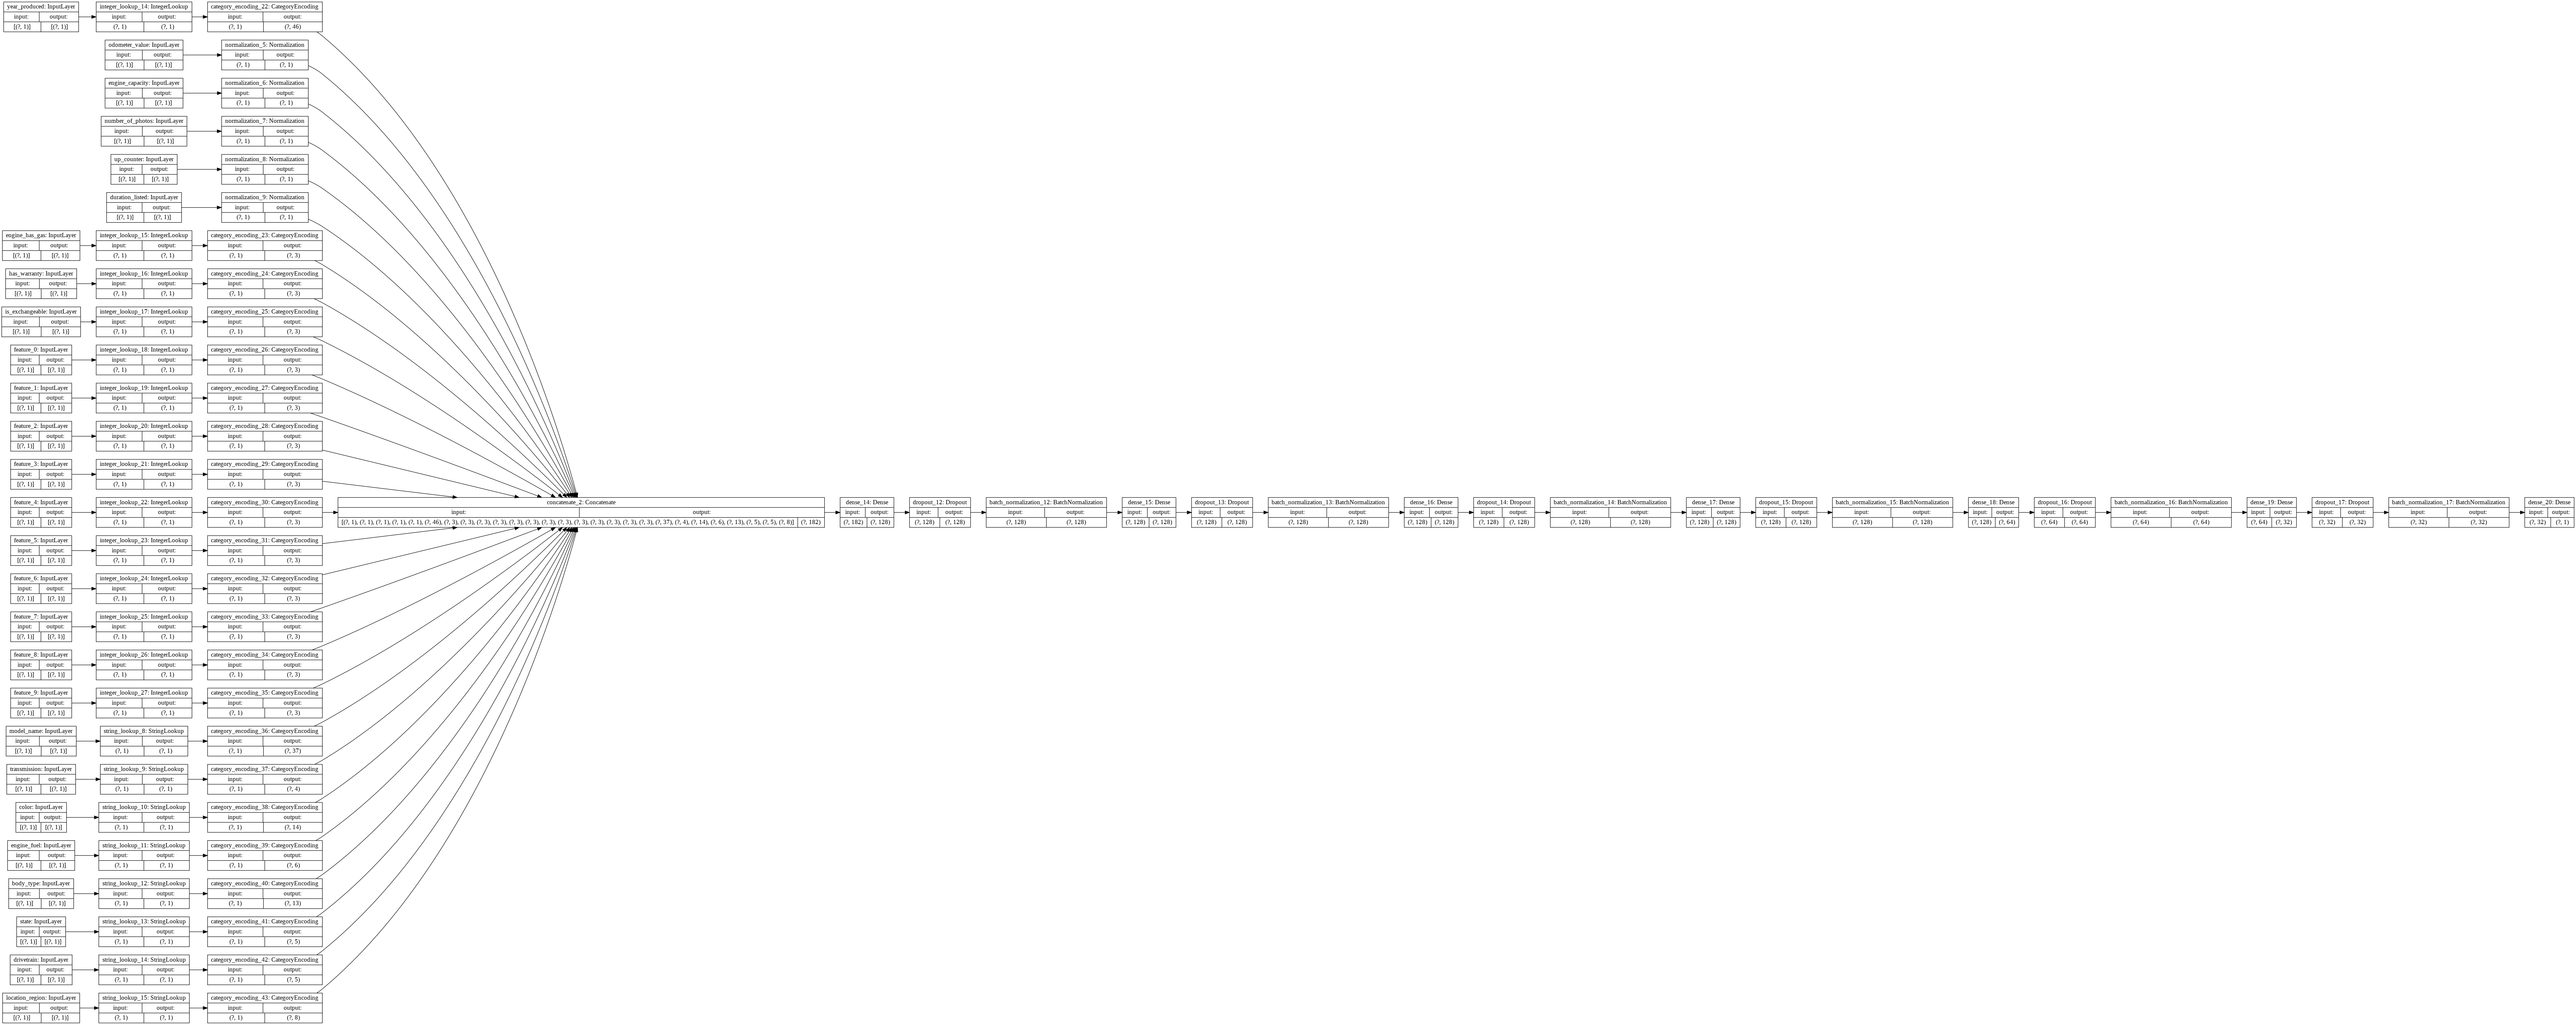

In [35]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training

In [36]:
history = model.fit(train_ds, 
                    epochs=5000, 
                    validation_data=val_ds,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', 
                                                                mode='min', 
                                                                patience=10),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='root_mean_squared_error', 
                                                                    factor=0.1,)])

Epoch 1/5000
36/36 [==============================] - 1s 31ms/step - loss: 51044296.0000 - root_mean_squared_error: 7144.5293 - r2_adj: -1.1329 - val_loss: 55287856.0000 - val_root_mean_squared_error: 7435.5806 - val_r2_adj: -1.1196
Epoch 2/5000
36/36 [==============================] - 1s 15ms/step - loss: 51033308.0000 - root_mean_squared_error: 7143.7603 - r2_adj: -1.1415 - val_loss: 55299568.0000 - val_root_mean_squared_error: 7436.3682 - val_r2_adj: -1.1201
Epoch 3/5000
36/36 [==============================] - 1s 15ms/step - loss: 51013212.0000 - root_mean_squared_error: 7142.3535 - r2_adj: -1.1321 - val_loss: 55306912.0000 - val_root_mean_squared_error: 7436.8618 - val_r2_adj: -1.1204
Epoch 4/5000
36/36 [==============================] - 1s 15ms/step - loss: 50990788.0000 - root_mean_squared_error: 7140.7832 - r2_adj: -1.1246 - val_loss: 55286180.0000 - val_root_mean_squared_error: 7435.4678 - val_r2_adj: -1.1196
Epoch 5/5000
36/36 [==============================] - 1s 15ms/step -

# Plot Metrics

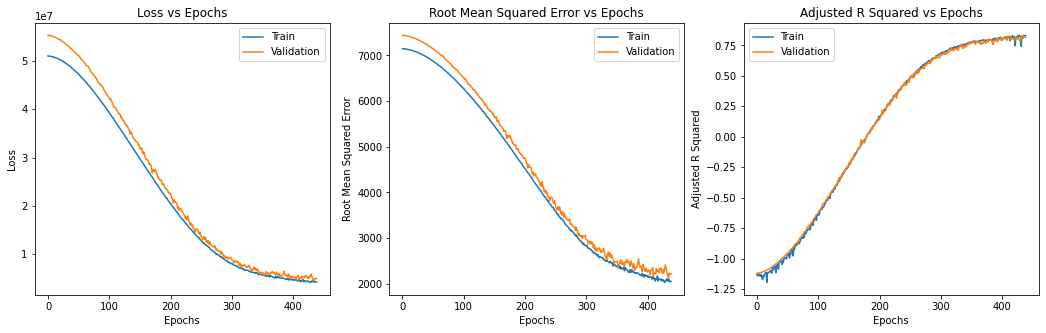

In [37]:
import matplotlib.pyplot as plt
frame = pd.DataFrame(history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(18,5))

# Loss plot
ax = fig.add_subplot(131)
ax.plot(epochs, frame['loss'], label="Train") 
ax.plot(epochs, frame['val_loss'], label="Validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Root Mean Squared Error plot
ax = fig.add_subplot(132)
ax.plot(epochs, frame['root_mean_squared_error'], label="Train") 
ax.plot(epochs, frame['val_root_mean_squared_error'], label="Validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Root Mean Squared Error") 
ax.set_title("Root Mean Squared Error vs Epochs") 
ax.legend()

# R Squared plot
ax = fig.add_subplot(133)
ax.plot(epochs, frame['r2_adj'], label="Train") 
ax.plot(epochs, frame['val_r2_adj'], label="Validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Adjusted R Squared")
ax.set_title("Adjusted R Squared vs Epochs")
ax.legend()

plt.show()

# Inference

In [42]:
print('Evaluate Model')
results = model.evaluate(test_ds)
print(f'\nLoss: {results[0]}\nRMSE: {results[1]}\nAdjusted R Squared: {results[2]}')


Evaluate Model
11/11 [==============================] - 0s 9ms/step - loss: 4543087.5000 - root_mean_squared_error: 2131.4519 - r2_adj: 0.8260

Loss: 4543087.5
RMSE: 2131.451904296875
Adjusted R Squared: 0.8259631991386414
